<a href="https://www.kaggle.com/code/merajhesh/loan-default-prediction?scriptVersionId=249786158" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%load_ext autoreload
%autoreload 2

## Introduction

Banks earn a major revenue from lending loans. But it is often associated with risk. The borrower's may default on the loan. To mitigate this issue, the banks have decided to use Machine Learning to overcome this issue. They have collected past data on the loan borrowers & would like you to develop a strong ML Model to classify if any new borrower is likely to default or not.

The dataset is enormous & consists of multiple deteministic factors like borrowe's income, gender, loan pupose etc. The dataset is subject to strong multicollinearity & empty values. Can you overcome these factors & build a strong classifier to predict defaulters?

Acknowledgements:
This dataset has been referred from Kaggle.

### Objective:
Understand the Dataset & cleanup (if required).
Build classification model to predict weather the loan borrower will default or not.
Also fine-tune the hyperparameters & compare the evaluation metrics of vaious classification algorithms.

In [2]:
import numpy as np 
import scipy.stats as ss
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy as spy
# mlflow
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
import sklearn.preprocessing as sp
import sklearn.compose as sc
from loan_default.utils import (
    categorical_missing,
    numerical_missing,
    modified_zscore,
    mahalanobis_distance,
    normality_test,
    mlflow_models,
    mlflow_metrics,
    prepare_train_test,
 )
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.option_context('mode.use_inf_as_na', True)

In [3]:
data = pd.read_csv('data/Loan_Default.csv')
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [4]:
data.dtypes

ID                             int64
year                           int64
loan_limit                    object
Gender                        object
approv_in_adv                 object
loan_type                     object
loan_purpose                  object
Credit_Worthiness             object
open_credit                   object
business_or_commercial        object
loan_amount                    int64
rate_of_interest             float64
Interest_rate_spread         float64
Upfront_charges              float64
term                         float64
Neg_ammortization             object
interest_only                 object
lump_sum_payment              object
property_value               float64
construction_type             object
occupancy_type                object
Secured_by                    object
total_units                   object
income                       float64
credit_type                   object
Credit_Score                   int64
co-applicant_credit_type      object
a

Before we proceed with outlier detection and in order to make the investigation simpler, as a rule of thumb we will throw out those samples for which 15% of features have a missing values. This not only makes the analysis easier, it is also rational because a sample which is "contaminated" by so many missing values is not rather worthy of imputation. 

In [ ]:
l = math.floor(len(data.columns)/5)
print(l)
print(' # Samples that will be deleted: ' + str((data.isna().sum(axis = 1) >= l).sum()))
df = data[data.isna().sum(axis = 1) < l]
df = df.reset_index(drop = True)
df.head()

6
 # Samples that will be deleted: 15163


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


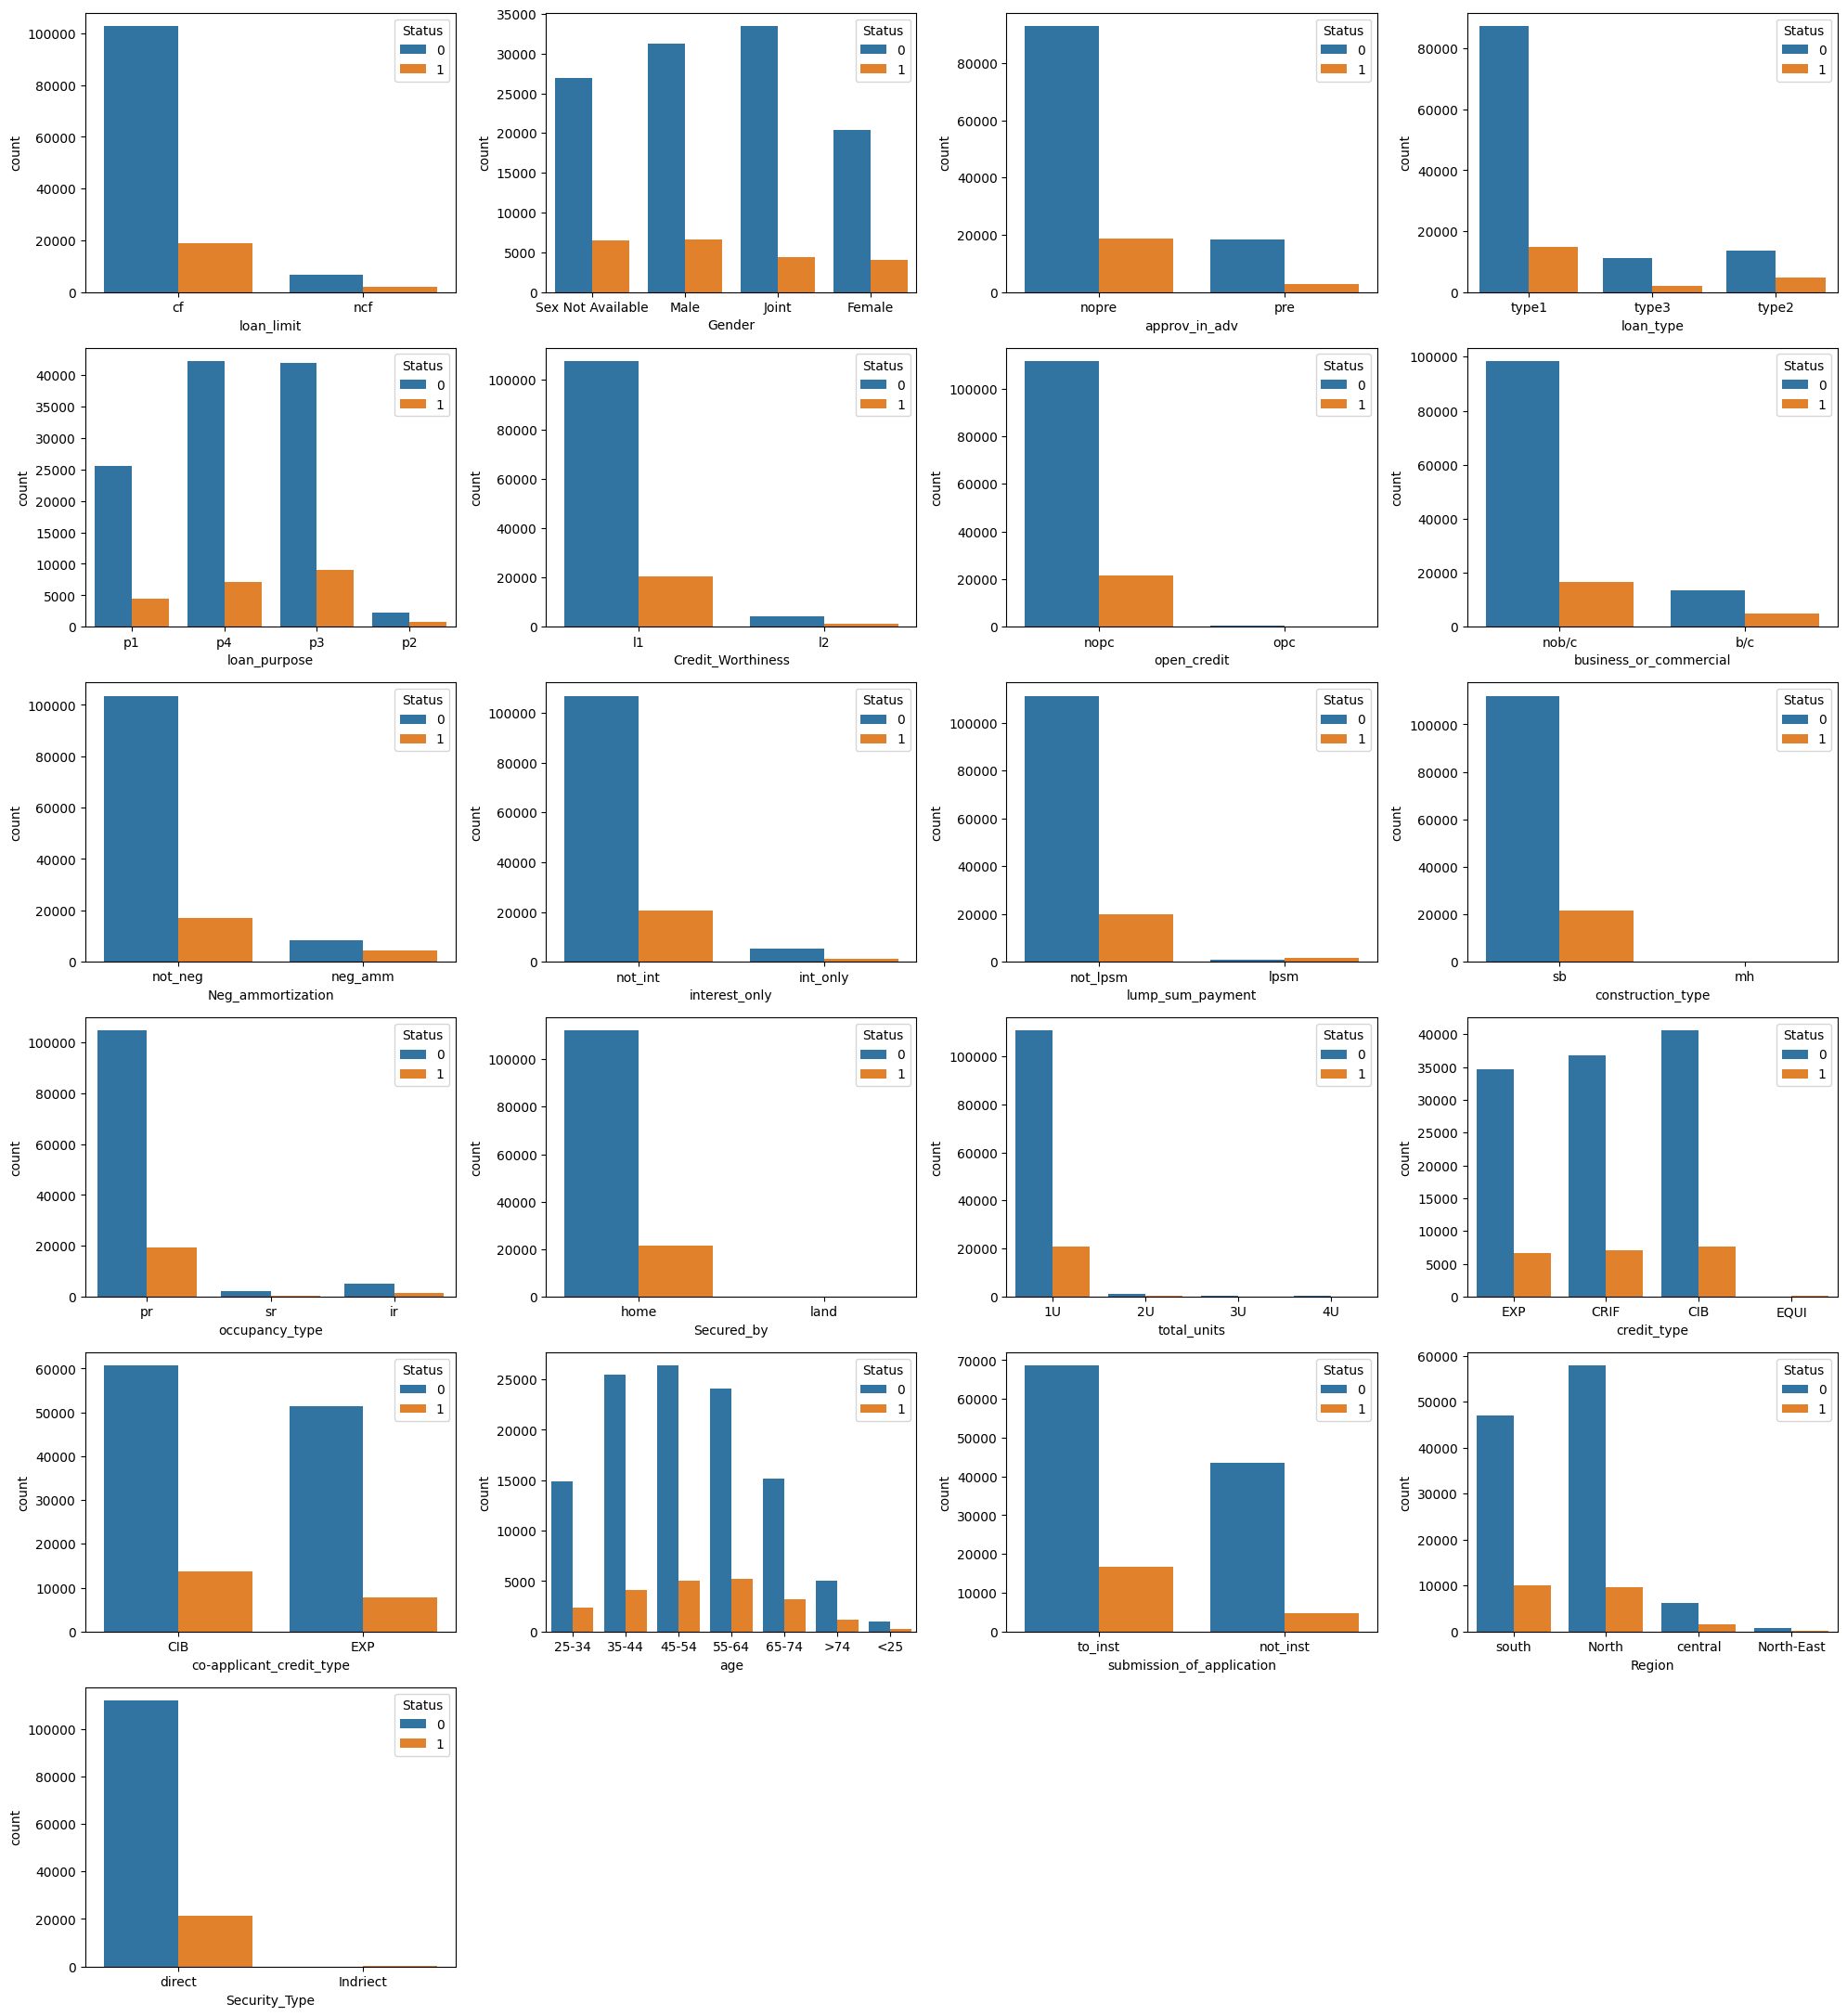

In [ ]:
# count plots of categorical variables 
df_obj = df.select_dtypes(include = 'object')
df_obj_status = df_obj.join(df['Status'])

plt.figure(figsize=(20,25))
for i, col in enumerate(df_obj):
    plt.tight_layout()
    plt.subplot(7,4,i+1)
    sns.countplot(data = df_obj_status, x = col, hue='Status')

In [ ]:
# log transformation
df_log_transformed = df.copy()
df_log_transformed = df_log_transformed[(df_log_transformed['income'] != 0) & (df_log_transformed['income'].isna() == False)]
df_log_transformed.loc[:,'income'] = np.log10(df_log_transformed.loc[:,'income'])
df_log_transformed['loan_amount'] = df_log_transformed['loan_amount'].astype(np.float64)
df_log_transformed.loc[:,'loan_amount'] = np.log10(df_log_transformed.loc[:,'loan_amount'] + 1)
df_log_transformed.loc[:,'property_value'] = np.log10(df_log_transformed.loc[:,'property_value'] + 1)
df_log_transformed.loc[:,'Upfront_charges'] = np.log10(df_log_transformed.loc[:,'Upfront_charges'] + 1)
df_log_transformed = df_log_transformed[df_log_transformed['LTV'] <= 100]
df_log_transformed.replace([np.inf, -np.inf], 0, inplace=True)

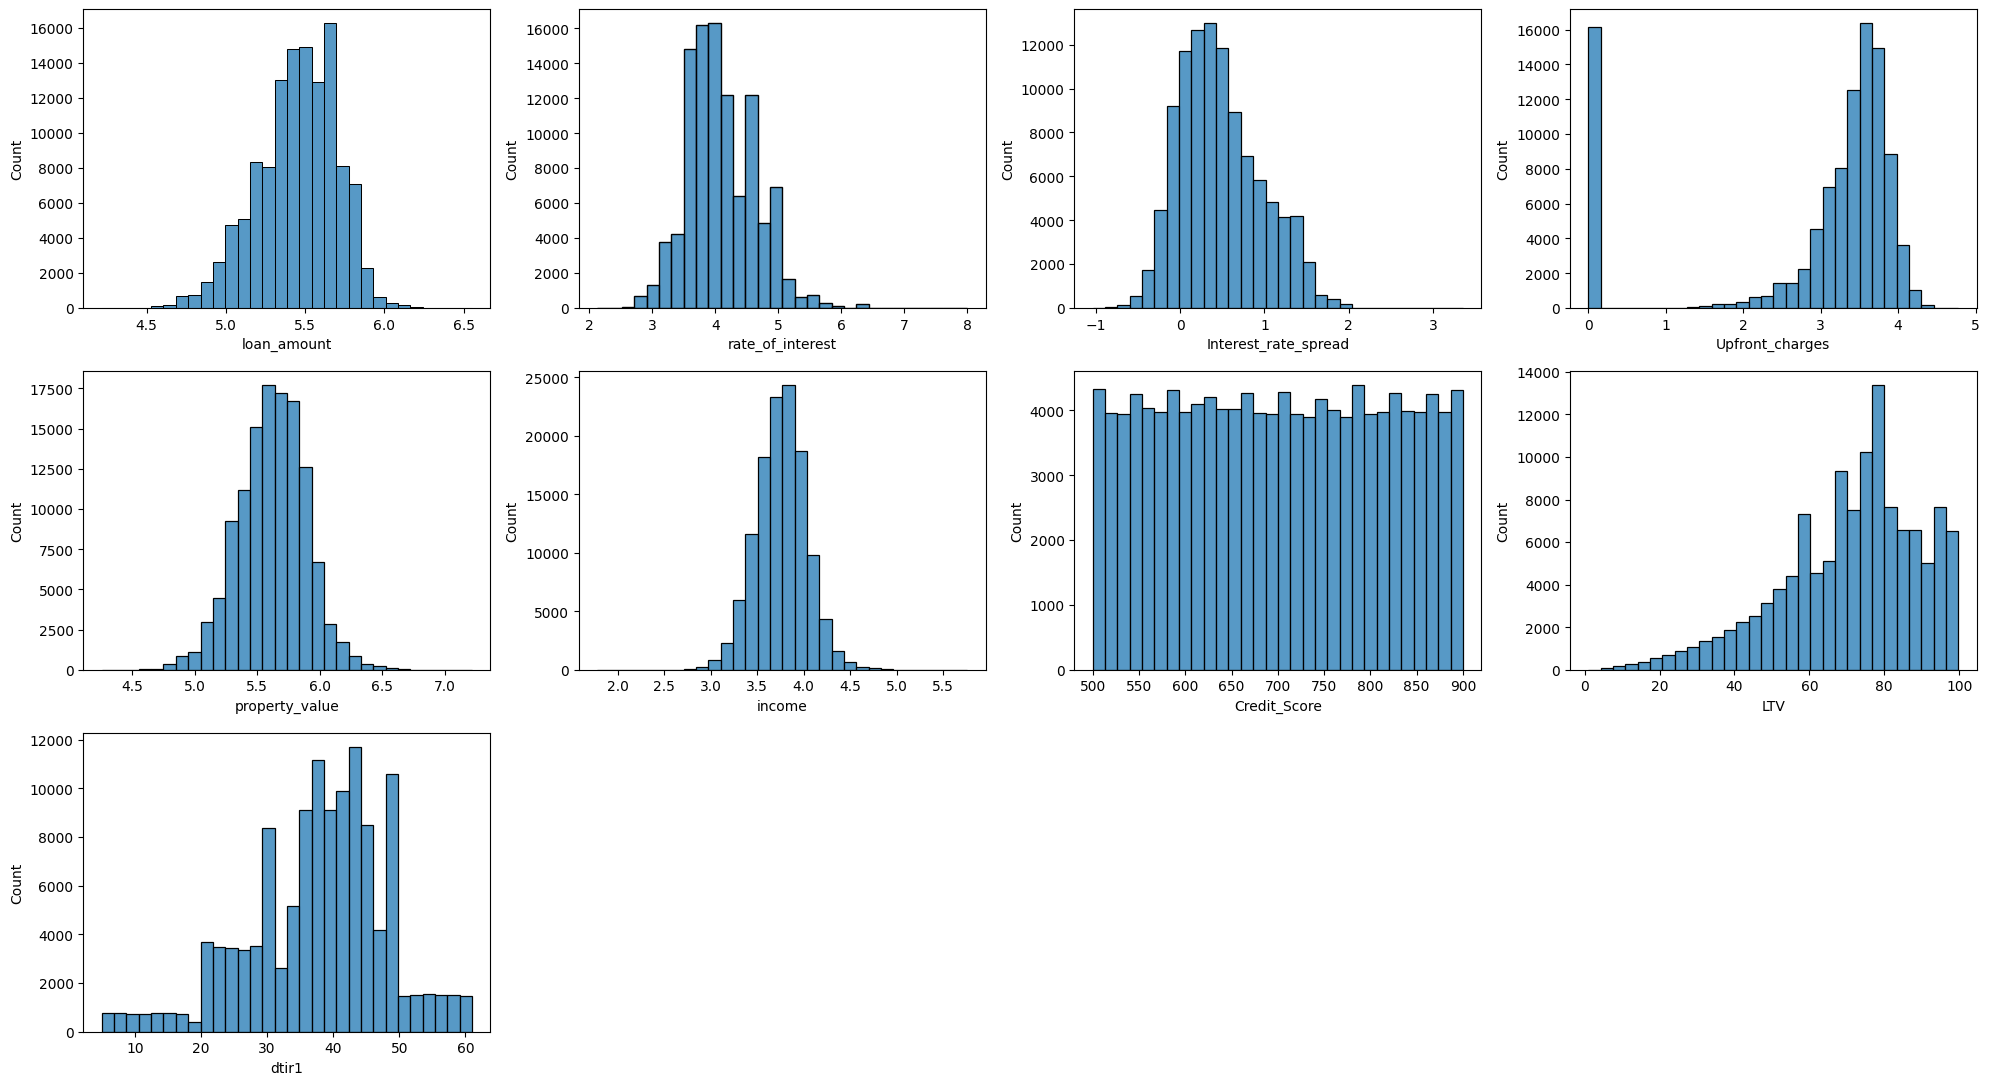

In [8]:
#  histograms of numerical variables
pd.option_context('mode.use_inf_as_na', True)
df_num = df_log_transformed.select_dtypes(exclude = 'object')
df_sub_num = df_num.drop(columns = ['ID', 'year', 'term', 'Status'])
#'LTV', 'income', 'property_value', 'Upfront_charges', 'rate_of_interest', 'Interest_rate_spread'
plt.figure(figsize=(20,25))
for i, col in enumerate(df_sub_num):
    if col != 'Status':
        plt.tight_layout()
        plt.subplot(7,4,i+1)
        sns.histplot(data = df_sub_num, x = col, bins = 30)

# Outliers
Here is how an outlier is defined according to Barnett and Lewis (19844: s "an observation (or subset of observations) which appears to be inconsistent with the remainder of that set of data". We can view outliers from two point of views. First, by looking at each feature individually. In this case, an outlier is identified as a value which is not consistent with the rest of the observations for a specific feature. We can use methods like "modified zscore" and "IQR method" to identify these outliers. Second, by looking at the dependency between features, but in particular between the features and the target variable. A good approach would be to use with grouping of the data using pandas "crosstab". Then apply the methods above or calculate leverage or other distances such as Mahalanobis distance to identify outliers. 

In general, droping entries because they have been identified outliers by these methods should be done with cautious. It is always better to identify inconsitancy in data by applying EDA. 

### Loan to Value ratio (LTVr)

LTVr is the amount of loan divided by the value of the asset which is being purchased. LTVr cannot  be more than 100 %. 

count    133505.000000
mean         72.741030
std          39.976153
min           0.967478
25%          60.474860
50%          75.135870
75%          86.184211
max        7831.250000
Name: LTV, dtype: float64


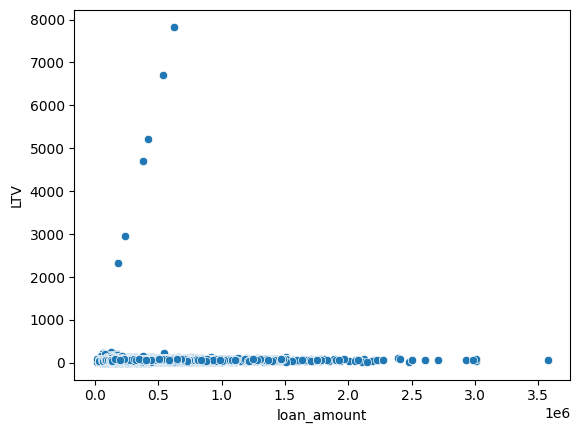

In [9]:
print(df['LTV'].describe())
sns.scatterplot(df, y = 'LTV', x = 'loan_amount')
plt.show()

Calculating asset values by loan amounts multiplied by LTVr clearly shows that these values are most probably entered by mistake. Additionally, we find a lot of entries with missing "rate of interest" among the entries with LTVr greater than 100, which is suspecious! We can assume that these values are entered by mistake and correct them by dividing by 100. However, this is too risky and would be more wise to delete these entries. Just in case:

https://en.wikipedia.org/wiki/Loan-to-value_ratio#:~:text=Higher%20LTV%20ratios%20are%20primarily,100%25%20are%20called%20underwater%20mortgages.

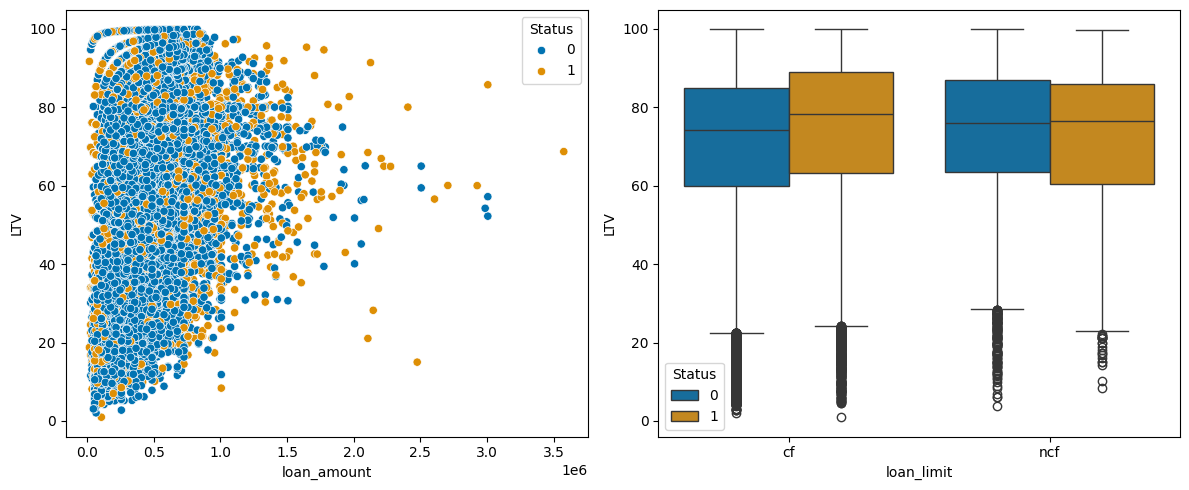

In [10]:
df_out = df.copy()
df_out = df_out[df_out['LTV'] <= 100]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(df_out, y = 'LTV', x = 'loan_amount', hue = 'Status', palette = 'colorblind', ax = ax[0])
sns.boxplot(data = df_out, x = 'loan_limit', y = 'LTV', hue = 'Status', palette = 'colorblind', ax = ax[1])
plt.tight_layout()
plt.show()

### Rate of interest
There is also an unusal sample with zero rate of interest. Since interest rate spread is also an outlier for this sample we will assume that the sample is contaminated and it is better to drop it. 

In [11]:
df_out = df_out[df_out['rate_of_interest'] != 0]
df_out

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133502,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
133503,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
133504,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
133505,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


### Income

Dept to income ratio is non-zero for all samples which do not have missing values. However, income is zero in many cases. This cannot be true! Instead considering these as outliers, we think they can be considered as missing values. We will discuss this case in the next chapter. 

Additionally, some incomes are really low for those who are getting a loan for secondery or investment residency (occypancy type of sr and ir). 

In [12]:
df_tmp = df_out[df_out['income'] > 0] 
pd.crosstab(df_tmp['occupancy_type'], df_tmp['Status'], values = df_tmp['income'], aggfunc = 'median').round(2)

Status,0,1
occupancy_type,,
ir,8700.0,6540.0
pr,5880.0,4500.0
sr,10080.0,7890.0


In [13]:
df_tmp = df_out[df_out['income'] > 1500] 
pd.crosstab(df_tmp['occupancy_type'], df_tmp['Status'], values = df_tmp['income'], aggfunc = 'median').round(2)

Status,0,1
occupancy_type,,
ir,8820.0,6780.0
pr,5880.0,4740.0
sr,10080.0,7980.0


However, by comparing two cases where one only considers incomes above 1500 (a salary which one earns almost with minimum wage per hour), there is no concrete evidance that there is systematic sampling error behind these observations.

### Modified Zscore



We will derive the modified zscores for the numeric features just to get a sense of the extent of outliers recognized by this method. Later during modeling we will remove such entries to see if removing such entries it has "reasonable" impact on the performance of the models. By reasonable we mean if test accuracy is not impacted or overfitting does not occur. 

In [14]:
df_num_num = df.copy()
df_num_num = df_num_num.select_dtypes(exclude = 'object')
df_num_num = df_num_num.drop(['ID', 'year', 'Status', 'Upfront_charges'], axis = 1)
df_num_num = df_num_num[df_num_num['income'] > 0]

### Mahalanobis Distance

We will investigate this distance after dealing with missing data.

# Treating Missing Data

## Estimation

In this approach we estimate missing information by using each feature individually.

In [15]:
print("#Samples: " + str(len(df)))
df_out.isna().sum()

#Samples: 133507


ID                               0
year                             0
loan_limit                    2923
Gender                           0
approv_in_adv                  799
loan_type                        0
loan_purpose                   106
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             20163
Interest_rate_spread         20307
Upfront_charges              23300
term                            29
Neg_ammortization              112
interest_only                    0
lump_sum_payment                 0
property_value                   0
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        8775
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            144
submission_of_applic

In [16]:
df_out = df_out.reset_index(drop = True)
df_missing = df_out.copy()
income_est = pd.crosstab(df_out['Status'], df_out['loan_purpose'], values = df_out['income'], aggfunc = 'median')
income_est

loan_purpose,p1,p2,p3,p4
Status,,,,
0,6240.0,4800.0,5160.0,6960.0
1,4740.0,3360.0,4200.0,5400.0


**Income** is log-normally distributed (histrogram suffices for us as evidance; however tests of normality can also be applied). To handle missing data, we can either impute using the mean of the log-transformed values or the median of the original income values. Additionally, we can improve the imputation by incorporating loan status and loan purpose as grouping variables. This is because income seems to differ noticably between these groups. In particular, we replace missing income values with the corresponding estimator (either the mean of the log-transformed values or the median of the original values) derived from the subset of data within each loan status group. This approach ensures that the imputation reflects differences across loan statuses. Note that incomes with zero values are also considered as missing. 

In [17]:
df_cleaned_0 = numerical_missing(df_missing, income_est, 'income', ['Status', 'loan_purpose'])
df_cleaned_0.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


loan_amount             0.435843
rate_of_interest       -0.036748
Interest_rate_spread   -0.136621
term                   -0.054326
property_value          0.409585
income                  1.000000
Credit_Score            0.000994
LTV                    -0.062389
dtir1                  -0.273364
Name: income, dtype: float64


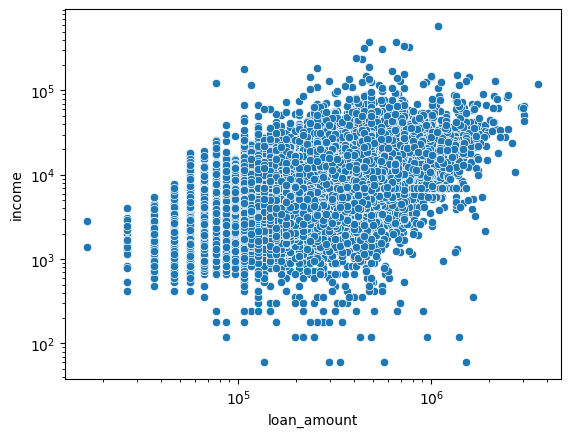

In [18]:
# income
print(df_cleaned_0.select_dtypes(exclude = 'object').drop(['ID', 'year', 'Status', 'Upfront_charges'], axis = 1).corr()['income'])
sns.scatterplot(df_cleaned_0, y = 'income', x = 'loan_amount')
plt.xscale('log')
plt.yscale('log')
plt.show()

For a series of categorical features for which missing data is present, we can use either knn or binomial/multinomial distributions to impute the missing data. Among those are:
- age
- submission of application
- approved in advance (approv_in_adv)
- loan purpose
- Negative Ammortization
- loan limit

In [19]:
print(df_cleaned_0['age'].value_counts()) #multinomial
print('  ')
print(df_cleaned_0['submission_of_application'].value_counts()) #binomial
print('  ')
print(df_cleaned_0['approv_in_adv'].value_counts()) #binomial
print('  ')
print(df_cleaned_0['loan_purpose'].value_counts()) #multinomial
print('  ')
print(df_cleaned_0['Neg_ammortization'].value_counts()) #binomial
print('  ')
df['loan_limit'].value_counts() # binomial

age
45-54    31032
35-44    29244
55-64    28935
65-74    18124
25-34    16918
>74       6150
<25       1160
Name: count, dtype: int64
  
submission_of_application
to_inst     83856
not_inst    47707
Name: count, dtype: int64
  
approv_in_adv
nopre    110150
pre       20758
Name: count, dtype: int64
  
loan_purpose
p3    50570
p4    48813
p1    29303
p2     2915
Name: count, dtype: int64
  
Neg_ammortization
not_neg    119280
neg_amm     12315
Name: count, dtype: int64
  


loan_limit
cf     121819
ncf      8732
Name: count, dtype: int64

Similar to "age", "**loan term**" can be placed in brackets and treated as a categorical variable. There is not enough evidance of high correlation with other features. Hence, we will replace missing terms by using multinomial distribution where probabilities are estimated as the weights of each term interval.

In [20]:
df_cleaned_1 = categorical_missing(df_cleaned_0, 'age')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'submission_of_application')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'approv_in_adv')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'loan_purpose')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'loan_limit')
df_cleaned_1 = categorical_missing(df_cleaned_1, 'Neg_ammortization')

**Term** of a loan can be also an important factor in default. Term has few missing values. It can be seen that more than 80% of the loans are issued for 360 months or 30 years, and more than 95% for 15 years or more. The 30 years term is so dominant in the data that makes replacing the missing values a chance. Later in feature engineering we would bin this feature in few intervals, namely, <180, 180-240, 240-360. 

In [21]:
df_tmp = df_cleaned_1[df_cleaned_1['term'].isna() == False]
print(pd.crosstab(df_tmp['Status'], df_tmp['loan_purpose'], values = df_tmp['term'], aggfunc = 'mean'))
print(df_tmp['term'].value_counts())

loan_purpose          p1          p2          p3          p4
Status                                                      
0             351.834997  324.230032  328.301644  332.227472
1             347.048897  322.922652  333.966782  331.342832
term
360.0    107938
180.0     11607
240.0      5253
324.0      2515
300.0      2107
120.0       455
144.0       240
348.0       239
336.0       191
312.0       171
96.0        167
156.0       159
216.0       103
276.0        85
288.0        82
132.0        80
168.0        72
228.0        63
204.0        53
264.0        41
108.0        31
192.0        16
252.0         8
280.0         1
322.0         1
Name: count, dtype: int64


In [22]:
N = (df_tmp['term'].isna() == False).sum()
p1 = (df_tmp['term'] <= 180 ).sum()/N
p2 = ((df_tmp['term'] <=240 ) & (df_tmp['term'] > 180 )).sum()/N
p3 = (df_tmp['term'] > 240).sum()/N
pp = np.array([p1,p2,p3])
v = np.array([180,240,360])
df_cleaned_2 = categorical_missing(df_cleaned_1, 'term', probabilities = pp, values = v)

**Debt to Income Ratio (DTIR)** is another important feature which contains relatively large amount missing data. It incorporates debt, an important variable which can be the leading cause of default. Therefore, it is important to impute the missing data for this random variable. DTIR has a skewed distribution. Additionally, it does not indicate difference in distribution and first moments when marginal distributions conditioned on different categorical variables are taken into account. However, there is slight difference if we consider default and non-default cases. Hence, the median of DTIR for each default and non-default cases can be a good estimator for imputing missing DTIR. 

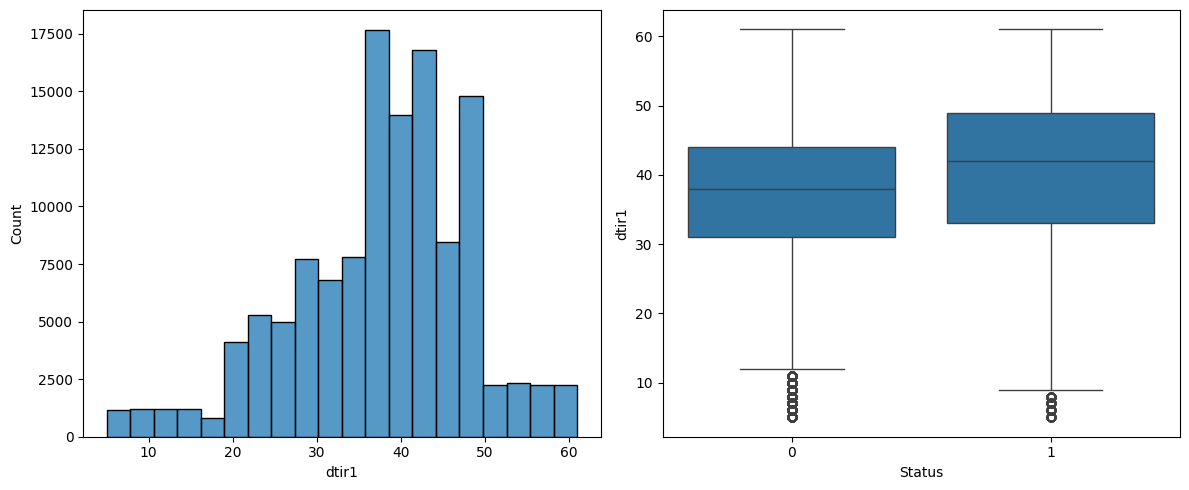

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_out, x = 'dtir1', bins = 20, ax = ax[0])
sns.boxplot(data = df_log_transformed, x = 'Status', y = 'dtir1', ax = ax[1])
plt.tight_layout()
plt.show()

In [24]:
# dtir1
ditr_est = df_cleaned_2.groupby(['Status'])['dtir1'].median()
df_cleaned_3 = numerical_missing(df_cleaned_2, ditr_est, 'dtir1', np.array(['Status']))
df_cleaned_3.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
4,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0


**Upfront Charges** seems to be dependent on loan type and loan purpose.  However, there are a lot of loans issued with zero upfront charges. For these cases, the fee is probably included in the loan amount itself. Banks usually do that, however, then the interest rates wil be calculated higher. We also keep in mind that the upfront charges are usually calculated as a percentage of loan amount. Hence, we do not know two things about missing data and we would like to estimate those. First, if the upfront charges were included in the loan. For these loans, the upfront charges would be zero. Second, what percentage of loan is considered as an upfront fee if this fee is not zero. We will do as follows: 1) we flip a coin for the fee to be included in the loan amount, i.e., fee being zero or not, 2) if not zero, then we calculated the fee as the loan amount multiplied by the mean percentage of non-zero upfront charges relative to loan amount. 

In [25]:
df_tmp = df_cleaned_3.copy()
where_missing = np.where(df_tmp['Upfront_charges'].isna())[0]
lul = len(where_missing)
pul = len(df_tmp[df_tmp['Upfront_charges'] == 0])/len(df_tmp[df_tmp['Upfront_charges'].isna() == False])
pul = np.array([pul, 1- pul])
u = (df_tmp[df_tmp['Upfront_charges'] > 0]['Upfront_charges'])
l = (df_tmp[df_tmp['Upfront_charges'] > 0]['loan_amount'])
ul = u*100/l
mul = ul.mean()
vul = np.array([0,mul])
mull = np.random.multinomial(1, pul, lul)
k = 0
t = []
for i in mull:
    k = k + 1
    t.append(vul[i == 1][0])
df_tmp.loc[where_missing, 'Upfront_charges'] = t
df_cleaned_4 = df_tmp.copy().reset_index()

**Rate of Interest** and **Interest rate spread** look pretty much normal. We can impute the missing values by using the average of each column. 

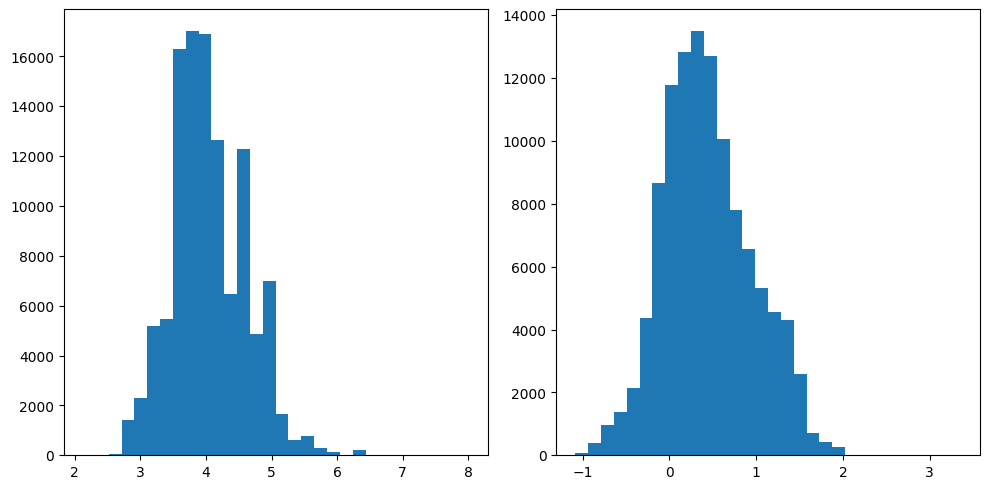

,rate_of_interest,Interest_rate_spread
count,111544.000000,111400.000000
mean,4.046697,0.443484
std,0.561194,0.512789
min,2.125000,-1.084100
25%,3.625000,0.077400
50%,3.990000,0.392000
75%,4.375000,0.777800
max,8.000000,3.357000


In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(df_cleaned_4['rate_of_interest'], bins = 30)
ax[1].hist(df_cleaned_4['Interest_rate_spread'], bins = 30)
plt.tight_layout()
plt.show()
df_cleaned_4[['rate_of_interest', 'Interest_rate_spread']].describe()

In [27]:
df_cleaned_5 = df_cleaned_4.copy()
df_cleaned_5['rate_of_interest'] = df_cleaned_5['rate_of_interest'].fillna(df_cleaned_5['rate_of_interest'].mean())
df_cleaned_5['Interest_rate_spread'] = df_cleaned_5['Interest_rate_spread'].fillna(df_cleaned_5['Interest_rate_spread'].mean())

## Regression/Classification

Alternatively, we can estimate missing values by treating the feature as a dependent variable and using othe features where missing data is absent as independent variable. 

For example, given the linear relationship between loan amount and income, simple linear regression can be applied to predict and impute the missing values of income. This approach leverages the predictive power of related variables to generate more accurate estimates for the missing data.

# Feature Engineering


**Terms** of mortgages are usually 15, 20, or 30 years. This can be easily seen from the data that terms are dominated by these few values. Therefore, binning terms and converting it to categorical variable seems to be a reasonable idea rather than using it as numerical variable. While there are different appraoches to binning (either simple statistical appraoches as equal width/frequency binning, or ML appraoches like k-means clustering), based on our knowledge of the data it seems to be reasonable to bin the the terms in the intervals named above. 

In [28]:
df_engineered_0 = df_cleaned_5.copy()
df_engineered_0['term'] = pd.cut(df_engineered_0['term'], bins = [0, 180, 240, 360], labels = ['short', 'medium', 'long'])

The **upfront charges** feature is a complicated one. There are many 0 values and many fees that are realy small relative to loan amount. There are also many values as large as 20000 or above (actually the max is around 60000). As we discussed above, the upfront fees are usually calculated as a percentage of loan amount. Additionally, in many cases the fee can be included in the loan amount. Considering these facts we proceed as follows: 1) we create another feature which encodes the upfront charges to be zero or not (in fact we treat really small values like 300 or less also as zero). 2) we transform the upfront charges to percentages of loan amount. These transformations have the advantage that they add information to the data where it is actually missing, i.e., the zero fees.

In [29]:
df_engineered_1 = df_engineered_0.copy()
df_engineered_1['Upfront_charges_y/n'] = np.where(df_engineered_1['Upfront_charges'] < 300, 0, 1)
df_engineered_1['Upfront_charges'] = df_engineered_1['Upfront_charges']*100/df_engineered_1['loan_amount']

We will also log Transformation to **income, property value, loan amount, and Credit Score**. The reason is that their distributions are right-skewed. Transformation helps with fairly representing the difference between values, in particular, reducing the impact of outliers. 

In [30]:
df_engineered_2 = df_engineered_1.copy()
df_engineered_2['income'] = np.log10(df_engineered_2['income'])
df_engineered_2['property_value'] = np.log10(df_engineered_2['property_value'])
df_engineered_2['loan_amount'] = np.log10(df_engineered_2['loan_amount'])

Of note, we could still apply scaling, however, we find it not necessary at this point as most of the numerical do not differ significantly in range of values. Later we can also investigate the model performances if numerical featrues are scaled. 

Before we apply encoding to categorical variables, we will drop the following columns: **ID, Year, LTV**. LTV will be dropped because its information is already contained in loan amount and property value. Credit type and secured by will be dropped because of the imbalanced representaions of their values in the dataset.

In [31]:
df_engineered_3 = df_engineered_2.drop(['ID', 'year', 'index', 'LTV', 'credit_type', 'Secured_by'], axis = 1)

We can apply traget encoding to **age and Region** because of their high cardinality. The most suitable encoding for **term and total units** is ordinal labling. This is because higher terms and higher number of units is highly correlated with the property value and the loan amount, and consequently with the default ratio. The rest of categorical variables can be encoded using dummy method, i.e., using N-1 features to represent N labels/categories.

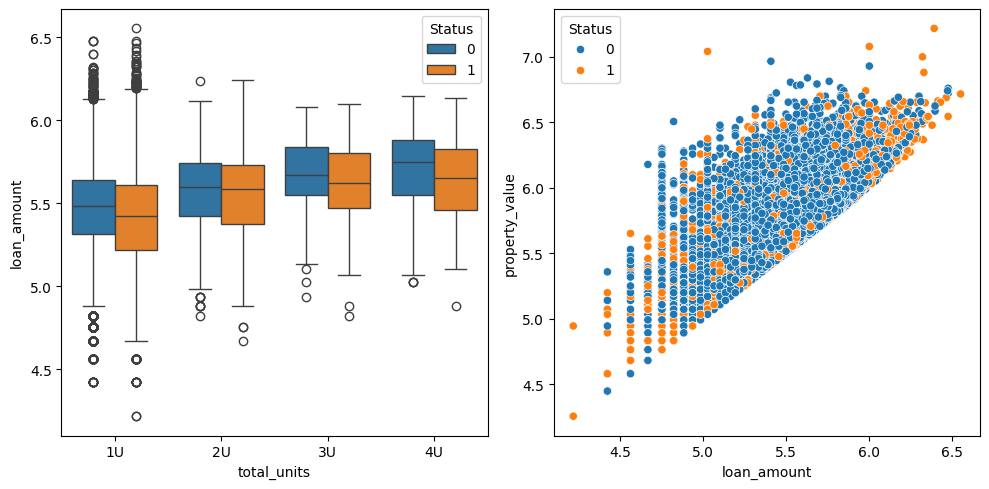

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df_engineered_3, x = 'total_units', y = 'loan_amount', hue = 'Status', ax = ax[0])
sns.scatterplot(df_engineered_3, x = 'loan_amount', y = 'property_value', hue = 'Status', ax = ax[1])
plt.tight_layout()
plt.show()

In [33]:
df_engineered_4 = df_engineered_3.copy()
# target
target_mean_age = df_engineered_4.groupby('age')['Status'].mean()
df_engineered_4['age'] = df_engineered_4['age'].map(target_mean_age)
target_mean_region = df_engineered_4.groupby('Region')['Status'].mean()
df_engineered_4['Region'] = df_engineered_4['Region'].map(target_mean_region)
#ordinal
Oencoder = sp.OrdinalEncoder()
df_engineered_4[['term', 'total_units']] = Oencoder.fit_transform(df_engineered_4[['term', 'total_units']]) + 1
# dummy

## # Specify the categorical columns to be one-hot encoded
cardinal_cols = df_engineered_4.select_dtypes(include = 'object').columns

## # Define the ColumnTransformer with OneHotEncoder
## # drop='first' will drop the first category to avoid multicollinearity
column_transforms = sc.ColumnTransformer(transformers = [('onehot', sp.OneHotEncoder(drop='first'), cardinal_cols)], remainder='passthrough')

## # Apply the transformation
df_tmp = column_transforms.fit_transform(df_engineered_4[cardinal_cols])

## # Convert the result to a DataFrame for easier readability
## # Extract feature names after encoding
onehot_feature_names = column_transforms.named_transformers_['onehot'].get_feature_names_out(cardinal_cols)
df_tmp = pd.DataFrame(df_tmp, columns = onehot_feature_names)

## # drop original columns
df_engineered_4 = df_engineered_4.drop(cardinal_cols, axis = 1)

## # concat dataframes
df_engineered_4 = pd.concat([df_engineered_4, df_tmp], axis=1)


df_engineered_4[['Credit_Score', 'Status', 'Upfront_charges_y/n']] = df_engineered_4[['Credit_Score', 'Status', 'Upfront_charges_y/n']].astype('float64')

# Modeling

In the following we build a machine learning pipeline to evaluate the performance of different models on a dataset using cross-validation and hyperparameter tuning. Below is a summary of the main components:

1. **Train-Test Split**:  
   The function `train_test_splits` splits the dataset into training and testing sets based on a `test_size` of 50% and a random seed (`rn_state`) for reproducibility. It separates the target variable (`Status`) from the feature set.

2. **Hyperparameter Configuration**:  
   A list `hparameters` contains:
   - Names of models (Logistic Regression, KNN, Random Forests, and Boosted Trees).
   - Corresponding model objects or placeholders.
   - Binary flags indicating whether dummy variables are included.
   - Dictionaries with hyperparameter options for each model to facilitate grid search.

3. **Model Performance Logging**:  
   The function `mlflow_metrics` calculates and logs key performance metrics (accuracy, precision, recall, ROC/AUC) for both training and testing datasets using the `mlflow` library.

4. **Pipeline and Scaling**:  
   - Scales numeric features using `MinMaxScaler` through a `Pipeline` and `ColumnTransformer`.
   - Uses `GridSearchCV` to optimize the hyperparameters for each model.
   - Logs the best hyperparameters, fits the model, and records the predictions.

5. **Automated Model Training**:  
   The `mlflow_models` function:
   - Iterates through the list of models and their respective hyperparameters.
   - Chooses the appropriate dataset (with or without dummy variables).
   - Logs experiment details to `mlflow`, trains the models, and evaluates performance metrics.

In [34]:
# Train-Test Split (imputation fit on train only)
test_size = 0.5
rn_state = 1818
train_with_dummies, test_with_dummies, train_without_dummies, test_without_dummies = prepare_train_test(
    df_out, test_size=test_size, rn_state=rn_state
)


In [35]:
# Hyperparameter Values
hparameters = []

hparameters.append(['LogisticRegression', 'KNN', 'RandomForests', 'BoostedTrees']) # tags
hparameters.append([LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), HistGradientBoostingClassifier()]) # models
hparameters.append([1, 1, 0, 0]) # dummy or not
hparameters.append([{'C':[0.5,1], 'max_iter':[100,200]}, #Logistic Regression,
                    {'n_neighbors':[3,5,10]}, #KNN
                    {'n_estimators': [50, 100, 200], 'criterion': ['log_loss'], 'max_depth': [5, 10], 'min_samples_split': [10,100]}, # Random Forests
                    {'l2_regularization': [0.1,0.5,0.9], 'min_samples_leaf': [10, 100], 'max_depth': [5, 10], 'learning_rate': [0.1,0.5]} #XGB
                   ]) 

scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

numeric_features = [
    'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges',
    'property_value', 'income', 'dtir1', 'Credit_Score'
]

In [36]:
# Tracking URI is supplied via mlflow_models(tracking_uri="file:mlruns")
# Nothing else needed here to avoid double-setting.
# # accessing mlflow ui
# mlflow ui --backend-store-uri file:mlruns --port 5000
# http://127.0.0.1:5000

In [39]:
mlflow_models(
    hparameters,
    train_with_dummies,
    test_with_dummies,
    train_without_dummies,
    test_without_dummies,
    numeric_features,
    scoring=scoring,
    experiment_name="loan-default-exp",
    tracking_uri="file:mlruns",
)


Fitting 7 folds for each of 4 candidates, totalling 28 fits
[CV 1/7] END LogisticRegression__C=0.5, LogisticRegression__max_iter=100; accuracy: (train=0.886, test=0.883) precision: (train=0.725, test=0.713) recall: (train=0.416, test=0.407) roc_auc: (train=0.927, test=0.926) total time=   0.0s
[CV 2/7] END LogisticRegression__C=0.5, LogisticRegression__max_iter=100; accuracy: (train=0.886, test=0.883) precision: (train=0.728, test=0.693) recall: (train=0.416, test=0.429) roc_auc: (train=0.927, test=0.924) total time=   0.0s
[CV 3/7] END LogisticRegression__C=0.5, LogisticRegression__max_iter=100; accuracy: (train=0.886, test=0.889) precision: (train=0.728, test=0.738) recall: (train=0.412, test=0.436) roc_auc: (train=0.926, test=0.931) total time=   0.0s
[CV 4/7] END LogisticRegression__C=0.5, LogisticRegression__max_iter=100; accuracy: (train=0.887, test=0.880) precision: (train=0.726, test=0.703) recall: (train=0.427, test=0.389) roc_auc: (train=0.928, test=0.923) total time=   0.1s


2026/01/06 16:01:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fitting 7 folds for each of 3 candidates, totalling 21 fits
[CV 1/7] END KNN__n_neighbors=3; accuracy: (train=0.982, test=0.968) precision: (train=0.903, test=0.847) recall: (train=0.988, test=0.966) roc_auc: (train=0.999, test=0.988) total time=   0.8s
[CV 2/7] END KNN__n_neighbors=3; accuracy: (train=0.982, test=0.967) precision: (train=0.904, test=0.842) recall: (train=0.987, test=0.969) roc_auc: (train=0.999, test=0.985) total time=   0.8s
[CV 3/7] END KNN__n_neighbors=3; accuracy: (train=0.982, test=0.966) precision: (train=0.904, test=0.839) recall: (train=0.989, test=0.963) roc_auc: (train=0.999, test=0.986) total time=   0.7s
[CV 4/7] END KNN__n_neighbors=3; accuracy: (train=0.981, test=0.966) precision: (train=0.901, test=0.844) recall: (train=0.986, test=0.957) roc_auc: (train=0.999, test=0.985) total time=   0.7s
[CV 5/7] END KNN__n_neighbors=3; accuracy: (train=0.982, test=0.969) precision: (train=0.903, test=0.850) recall: (train=0.988, test=0.967) roc_auc: (train=0.999, t

2026/01/06 16:04:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV 1/7] END RandomForests__criterion=log_loss, RandomForests__max_depth=5, RandomForests__min_samples_split=10, RandomForests__n_estimators=50; accuracy: (train=0.999, test=0.999) precision: (train=1.000, test=1.000) recall: (train=0.995, test=0.991) roc_auc: (train=1.000, test=1.000) total time=   1.3s
[CV 2/7] END RandomForests__criterion=log_loss, RandomForests__max_depth=5, RandomForests__min_samples_split=10, RandomForests__n_estimators=50; accuracy: (train=0.999, test=0.999) precision: (train=1.000, test=1.000) recall: (train=0.995, test=0.994) roc_auc: (train=1.000, test=1.000) total time=   1.1s
[CV 3/7] END RandomForests__criterion=log_loss, RandomForests__max_depth=5, RandomForests__min_samples_split=10, RandomForests__n_estimators=50; accuracy: (train=0.999, test=0.999) precision: (train=1.000, test=1.000) recall: (train=0.996, test=0.994) roc_auc: (train=1.000, test=1.000) total time=   1.1s
[CV 4/7] END RandomFo

d:\My Files\Projects\Python\Loan-Default Prediction\Case-Study-Loan-Default-Prediction\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/01/06 16:09:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Fitting 7 folds for each of 24 candidates, totalling 168 fits
[CV 1/7] END BoostedTrees__l2_regularization=0.1, BoostedTrees__learning_rate=0.1, BoostedTrees__max_depth=5, BoostedTrees__min_samples_leaf=10; accuracy: (train=1.000, test=1.000) precision: (train=1.000, test=0.999) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) total time=   3.2s
[CV 2/7] END BoostedTrees__l2_regularization=0.1, BoostedTrees__learning_rate=0.1, BoostedTrees__max_depth=5, BoostedTrees__min_samples_leaf=10; accuracy: (train=1.000, test=1.000) precision: (train=1.000, test=1.000) recall: (train=1.000, test=0.999) roc_auc: (train=1.000, test=1.000) total time=   0.5s
[CV 3/7] END BoostedTrees__l2_regularization=0.1, BoostedTrees__learning_rate=0.1, BoostedTrees__max_depth=5, BoostedTrees__min_samples_leaf=10; accuracy: (train=1.000, test=1.000) precision: (train=1.000, test=0.999) recall: (train=1.000, test=1.000) roc_auc: (train=1.000, test=1.000) total time=   0.8s
[CV 4/7] END Boosted

d:\My Files\Projects\Python\Loan-Default Prediction\Case-Study-Loan-Default-Prediction\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/01/06 16:12:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [40]:
mldf = mlflow.search_runs(experiment_names=["loan-default-exp"])
mldf[["tags.Model", 
        "metrics.Train Recall", "metrics.Test Recall",
        "metrics.Train Precision", "metrics.Test Precision",
        "metrics.Train ROC/AUC", "metrics.Test ROC/AUC",
        "metrics.Train Accuracy", "metrics.Test Accuracy"]].sort_values(by="tags.Model", ascending=False)

,tags.Model,metrics.Train Recall,metrics.Test Recall,metrics.Train Precision,metrics.Test Precision,metrics.Train ROC/AUC,metrics.Test ROC/AUC,metrics.Train Accuracy,metrics.Test Accuracy
1,RandomForests,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,LogisticRegression,0.454053,0.447114,0.716172,0.715073,0.710626,0.707318,0.888084,0.887281
5,LogisticRegression,0.454053,0.447114,0.716172,0.715073,0.710626,0.707318,0.888084,0.887281
2,KNN,0.979119,0.967402,0.865564,0.851730,0.975700,0.968351,0.973335,0.969007
4,KNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,BoostedTrees,0.999902,0.999902,0.999902,0.999803,0.999942,0.999933,0.999970,0.999954


# Results

Here’s a quick summary of how the models performed on the classification task:

1. **Boosted Trees**: Absolutely crushed it! Nearly perfect scores across the board, with recall, precision, accuracy, and ROC/AUC all above 99.9%. Super reliable and consistent.

2. **Random Forests**: Also performed really well, with recall above 99.3% and ROC/AUC around 99.7%. It’s not quite as good as Boosted Trees but still a strong contender.

3. **K-Nearest Neighbors (KNN)**: Did a decent job, with a test recall of 96.7% and ROC/AUC in the same range. However, its precision dropped to 84.2%, suggesting it might struggle with misclassifications.

4. **Logistic Regression**: Didn’t do so well, with a test recall of just 44.9% and ROC/AUC around 70.9%. It seems this model isn’t the best fit for this problem.

**Takeaway**: Boosted Trees is the clear winner, with Random Forests coming in as a solid second choice. KNN is okay but could use some tuning, while Logistic Regression probably isn’t worth pursuing further for this dataset.


# Conclusion

In conclusion, this pipeline demonstrates a robust approach to evaluating and tuning various machine learning models on the loan default dataset. However, the possibilities for exploration and improvement are vast. For instance, we could incorporate additional models to expand our analysis, experimenting with advanced algorithms like Support Vector Machines or Neural Networks. When it comes to data preprocessing, while we used MinMaxScaler here, other scaling techniques, or even skipping scaling altogether, might lead to better outcomes depending on the model and dataset characteristics. 

Currently, we utilized all available features for training, but we could enhance this process by identifying the most impactful ones through methods like Principal Component Analysis (PCA). This could streamline our model and potentially improve its performance. Regarding handling missing values, instead of the exhaustive imputation we applied, we might simply exclude rows with missing data if the dataset is sufficiently large or use sophisticated imputation strategies such as regression analysis to estimate missing values more accurately.What this hthis highlights is the near-limitless scope of innovatiML pipeline designcience. While the tools and methods for buildMLarning pipeline are well-d and limitedefined, the creative combinations, adaptations, and insights we can derive from them are infinite. It reminds me of the movie *The Legend of 1900*, where the protagonist plays on a finite set of piano keys but creates music that feelboarderlessor.